## Layout

A layout $L = (s_1, ..., s_k) : (d_1, ..., d_k)$ maps coordinates $\mathbf{c} = (c_1, \dots, c_k)$ to an index $p \in \mathbb{N}$:
$$
p = L(\mathbf{c}) = \sum_{i=1}^k c_i \cdot d_i = \sum_{i=1}^k L_i(c_i)
$$
Define $L_i = s_i:d_i$ where $s_i$ defines the domain and $d_i$ is a mapping stride.

A basic requirement for a layout is usually *non-overlapping*, meaning that if $R_i = \{ L_i(c_i) \}$ be the image of the $i$-th dimension, $\forall i \neq j$, we will have $R_i \cap R_j = \{0\}$ (i.e., *trivial Intersection*). 
This property is also named "disjoint", it implies
* Injective
* Reversibility of Addition (so that you can uncover $\mathbf{c}$ from $p$)

This notebook will use [./layout.py](layout.py) (a simplified implementation from reference [1, 2, 3, 4]) to illustrate certain basic layout algebra operations.

In these programs, we use `shape` and `stride` to name $s$ and $d$, besides, a layout’s shape and stride tuples must be *congruent*, that is, the two "tuples" need to have the same hierarchical structure.

domain and co-domain: 24 112


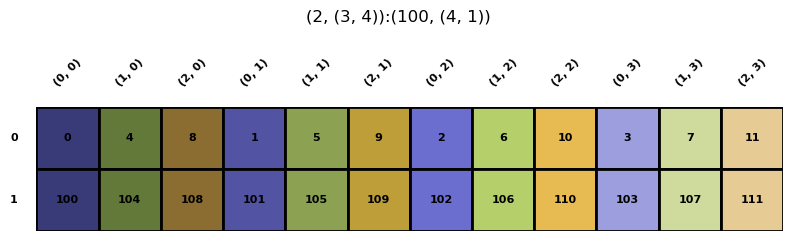

In [50]:
from layout import Layout
A = Layout(shape=(2, (3, 4)), stride=(100, (4, 1))).visualize()
print("domain and co-domain:", A.size(), A.cosize())

A layout without specifying the strides is default to the *colexicographical order*, i.e., a generalized column-major order where the strides are the *prefix products* of its shapes:

((2, 2), (3, 4)):((1, 2), (4, 12))

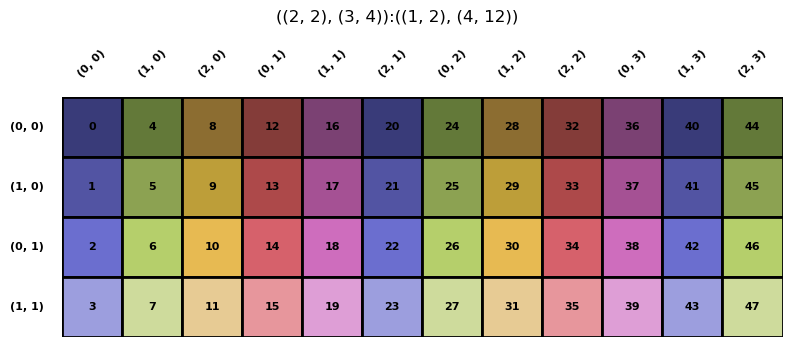

In [52]:
Layout(shape=((2, 2), (3, 4))).visualize()

## Coalesce
`coalesce` simplifies a layout. CuTe (Cutlass Tensor?) [1] defines that it targets and transform 3 cases:

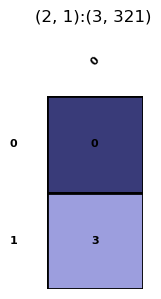

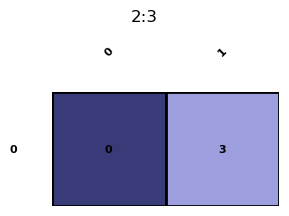

In [35]:
from layout import coalesce
# Case 1: s0:d0  ++  _1:d1  =>  s0:d0
A = Layout.from_string('(2,1):(3,321)').visualize()
B = coalesce(A).visualize()

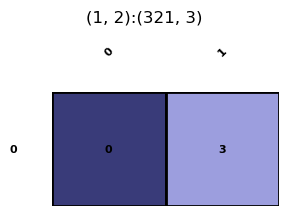

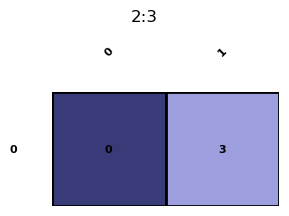

In [36]:
# Case 2: _1:d0  ++  s1:d1  =>  s1:d1
A = Layout.from_string('(1,2):(321, 3)').visualize()
B = coalesce(A).visualize()

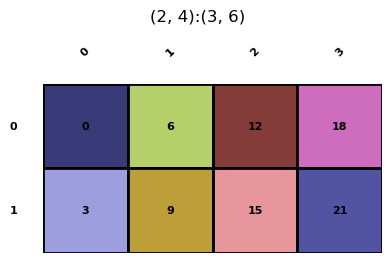

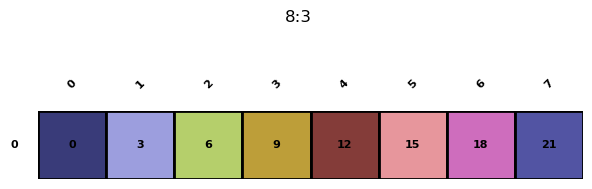

In [38]:
# Case 3: s0:d0  ++  s1:s0*d0  =>  s0*s1:d0
A = Layout.from_string('(2,4):(3,6)').visualize()
B = coalesce(A).visualize()

Note that it does not coalesce `(4, 2):(6, 3)` because CuTe coalesce from left-to-right. Vectorization of CuTe is usually done by `cute.max_common_layout` between source and destination layouts. It should be good for most of the common cases.

(4, 2):(6, 3)

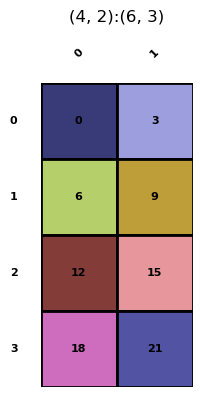

In [41]:
coalesce(Layout.from_string('(4,2):(6,3)')).visualize()

## Composition

As a result of the layout definition and requirement, we have a sum-distributive *composition*, namely,
$$
(A \circ B)(\mathbf{c}) = A \left( \sum_{i} B_i(c_i) \right) = \sum_{i} A(B_i(c_i)) = \sum_{i} (A \circ B_i)(c_i)
$$

Assume $A=A_s:A_d$ and $B_i(c_i) = c \cdot B_d$, then
$$
A(B_i(c_i)) = A(c_i \cdot B_d)
$$
which is essentially to determine a layout that produces every $B_d$-th element of $A$.

In layout algebra, this is defined as "dividing out" the first $d$ elements from the shape of $A$ starting from the left.
For example:
* `(3, 6, 2, 8) / 72 => (3/3), (6, 2, 8) / 24 => (1), (6, 2, 8) / 24`
* `(1), (6, 2, 8) / 24 => (1, 6/6), (2, 8) / 4 => (1, 1), (2, 8) / 4`
* `(1, 1), (2, 8) / 4 => (1, 1, 2/2), (8) / 2 => (1, 1, 1), (8) / 2`
* `(1, 1, 1), (8) / 2 => (1, 1, 1, 4)`

Double check by computing the size: $(3 \times 6 \times 2 \times 8) \div 72 = 4$.

To compute strides, the residuals of above are used to scale up the original strides:
* `(3, 6, 2, 8):(w, x, y, z) / 72 => (1, 2, 2, 4):(72w, 24x, 4y, 2z)`

Example: Calculate (2, 6, 4):(3, 16, 4) o (4, 3)

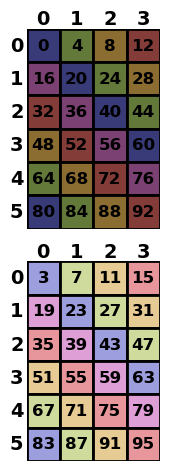

In [58]:
Layout(shape=(2, 6, 4), stride=(3, 16, 4)).visualize()

1. dividing out the shapes: `(2, 6, 4) / 6 => (1), (6, 4) / 3 => (1, 2, 4)`
2. dividing out the strides: `(3 * 6, 16 * 3, 4) => (18, 48, 4)`
3. modding out the shapes: `(1, 2, 4) % 4 => (min(4, 1)/min(4, 1), min(4, 2)/min(4, 1), min(4, 8)/min(4, 2)) => (1, 2, 2)`


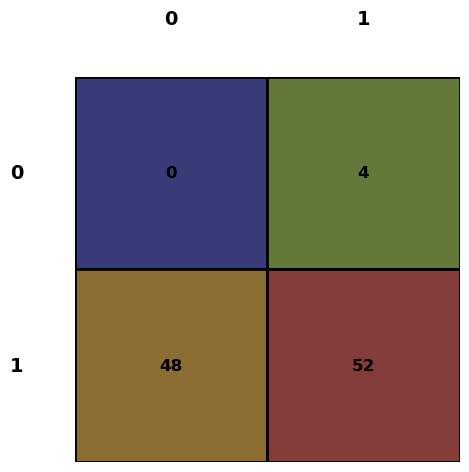

In [57]:
Layout(shape=(2, 2), stride=(48, 4)).visualize()

# Examples
Use [./layout.py](./layout.py) to illustrate some layout algebra basics.

In [33]:
from layout import Layout

import hilt.eager.api as cute
visualize_and_return = lambda layout: (layout, layout.visualize(dpi=50))[0]

## Permutation

Let's simulate a 3D shape and stride `(3, 2, 8):(2, 8, 1)`:

(3, 2, 8):(16, 8, 1)


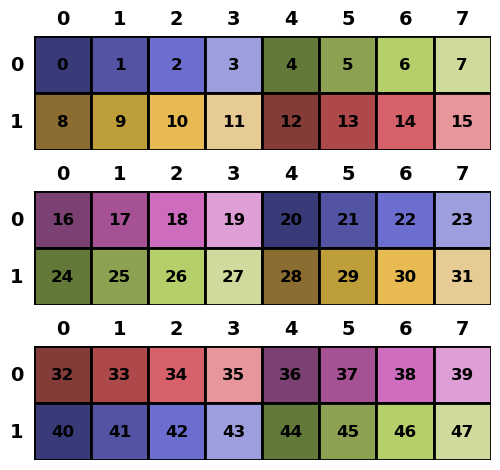

In [34]:
A = Layout(shape=(3, 2, 8), stride=(16, 8, 1))
print(A); A.visualize()

When it is reshaped, we remap both the shape and stride axises:

(2, 8, 3):(8, 1, 16)


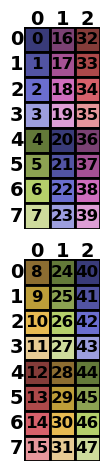

In [35]:
B = A.permute(1, 2, 0)
print(B); B.visualize()

## Composition

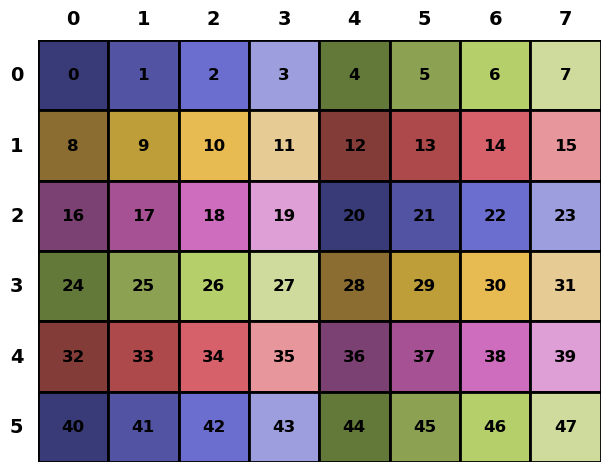

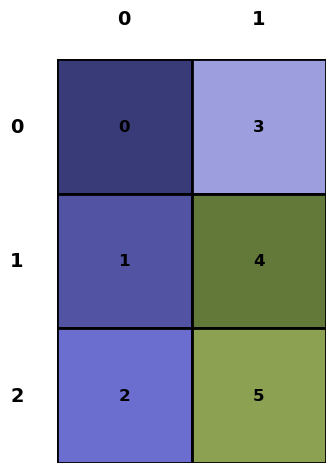

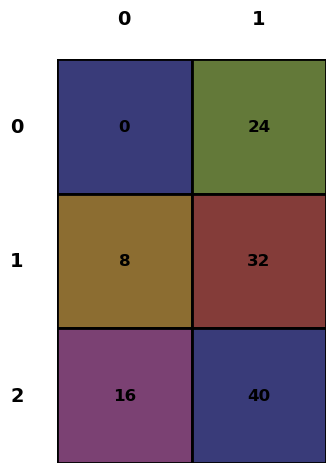

In [36]:
Layout(shape=(6, 8), stride=(8, 1)).visualize() # Base
Layout(shape=(3, 2), stride=(1, 3)).visualize() # Tiler
Layout(shape=(3, 2), stride=(8, 24)).visualize() # Composed

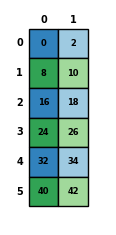

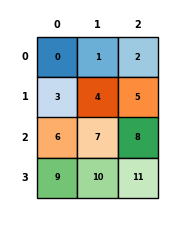

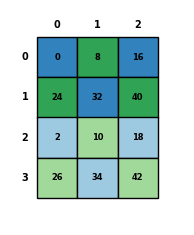

In [38]:
A = visualize_and_return(cute.make_layout(shape=(6, 2), stride=(8, 2)))
B = visualize_and_return(cute.make_layout(shape=(4, 3), stride=(3, 1)))
R = visualize_and_return(cute.make_layout(shape=((2, 2), 3), stride=((24, 2), 8)))

```
R( 0) = A(B( 0)) = A(B(0,0)) = A( 0) = A(0,0) =  0
R( 1) = A(B( 1)) = A(B(1,0)) = A( 3) = A(3,0) = 24
R( 2) = A(B( 2)) = A(B(2,0)) = A( 6) = A(0,1) =  2
R( 3) = A(B( 3)) = A(B(3,0)) = A( 9) = A(3,1) = 26
R( 4) = A(B( 4)) = A(B(0,1)) = A( 1) = A(1,0) =  8
R( 5) = A(B( 5)) = A(B(1,1)) = A( 4) = A(4,0) = 32
R( 6) = A(B( 6)) = A(B(2,1)) = A( 7) = A(1,1) = 10
R( 7) = A(B( 7)) = A(B(3,1)) = A(10) = A(4,1) = 34
R( 8) = A(B( 8)) = A(B(0,2)) = A( 2) = A(2,0) = 16
R( 9) = A(B( 9)) = A(B(1,2)) = A( 5) = A(5,0) = 40
R(10) = A(B(10)) = A(B(2,2)) = A( 8) = A(2,1) = 18
R(11) = A(B(11)) = A(B(3,2)) = A(11) = A(5,1) = 42
```

## Reference
[1] https://github.com/NVIDIA/cutlass/blob/acb45938e9cb3e4db8c1d75155b63d31791e0e5d/media/docs/cpp/cute/02_layout_algebra.md

[2] https://github.com/NVIDIA/cutlass/blob/acb45938e9cb3e4db8c1d75155b63d31791e0e5d/python/pycute/layout.py

[3] https://docs.modular.com/mojo/kernels/layout/layout

[4] https://github.com/modular/modular/blob/61603e2f4990e65b6c962389a13a1c288d0fb47b/max/kernels/src/layout/layout.mojo

[5] https://docs.modular.com/mojo/manual/layout/layouts/